In [1]:
#Install required library
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.3 MB/s eta 0:00:00


In [38]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization, Input
from keras.layers import GRU
from keras.callbacks import EarlyStopping

import transformers
from transformers import TFBertModel
from transformers import BertTokenizer

from wordcloud import WordCloud, STOPWORDS

import gensim.downloader as api
import nltk
from nltk.corpus import stopwords
import re


In [4]:
# Connect to google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# Read data
news_df = pd.read_csv('/content/drive/MyDrive/Data/train.csv')
submit_test = pd.read_csv('/content/drive/MyDrive/Data/test.csv')
submit_label = pd.read_csv('/content/drive/MyDrive/Data/submit.csv')
submit_test['label'] = submit_label.label

In [ ]:
#Check train data
news_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
#Check test data
submit_test.head()

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


In [ ]:
#Text Word statistics: min.mean, max and interquartile range

text_len = news_df.text.str.split().str.len()
text_len.describe()

count    20761.000000
mean       760.308126
std        869.525988
min          0.000000
25%        269.000000
50%        556.000000
75%       1052.000000
max      24234.000000
Name: text, dtype: float64

In [ ]:
#Title statistics 

title_len = news_df.title.str.split().str.len()
title_len.describe()

count    20242.000000
mean        12.420709
std          4.098735
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64

In [ ]:
# Check the information of the train data
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
# Check for null values (handled in data cleaning/preprocessing function)
news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
# Check records with null values in title column
news_df[news_df["title"].isnull()].head()

,id,title,author,text,label
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1
196,196,NaN,Raffie,They got the heater turned up on high.,1


In [ ]:
# Check records with null values in author column
news_df[news_df["author"].isnull()].head()

,id,title,author,text,label
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1


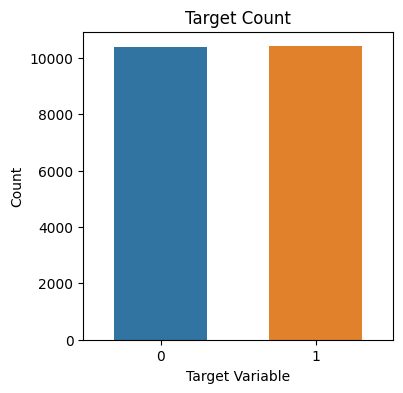

In [ ]:
#Countplot for target variable (indicates a balanced dataset)

plt.figure(figsize=(4,4))
sns.countplot(x="label", data=news_df, width=0.6)
plt.title('Target Count', fontsize=12)
plt.xlabel("Target Variable", fontsize = 10)
plt.ylabel("Count", fontsize = 10)

plt.show()

In [6]:
#Download nltk stopwords
nltk.download('stopwords')


# Clean the datasets
def clean_text(text):
    # Remove URLs from the text by replacing them with a space
    text = re.sub(r'http[\w:/\.]+', ' ', text)  
    #  Remove everything except characters, periods, and whitespace by replacing them with a space
    text = re.sub(r'[^\.\w\s]', ' ', text)
    # Remove non-alphabetic characters by replacing them with a space  
    text = re.sub('[^a-zA-Z]', ' ', text) 
    # Replace multiple consecutive whitespace characters with a single space
    text = re.sub(r'\s\s+', ' ', text) 
    # Convert the text to lowercase and removes leading/trailing whitespace
    text = text.lower().strip() 
    return text

def nltk_preprocessing(text):
    # Checks if text is an instance of a string (excludes null values in text)
    if isinstance(text, str):
        # Call the clean_text() function to clean the text
        text = clean_text(text)
        # Retrieve the stopwords for the English language
        stop_words = set(stopwords.words('english')) 
        # Join the words from the cleaned text that are not in the set of stopwords using a space as the separator
        text = ' '.join([word for word in text.split() if word not in stop_words]) 
    return text

# Apply text preprocessing using the nltk_preprocessing() function   
news_df['text'] = news_df['text'].apply(nltk_preprocessing).astype(str)
news_df['title'] = news_df['title'].apply(nltk_preprocessing).astype(str)
submit_test['text'] = submit_test['text'].apply(nltk_preprocessing).astype(str)
submit_test['title'] = submit_test['title'].apply(nltk_preprocessing).astype(str)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


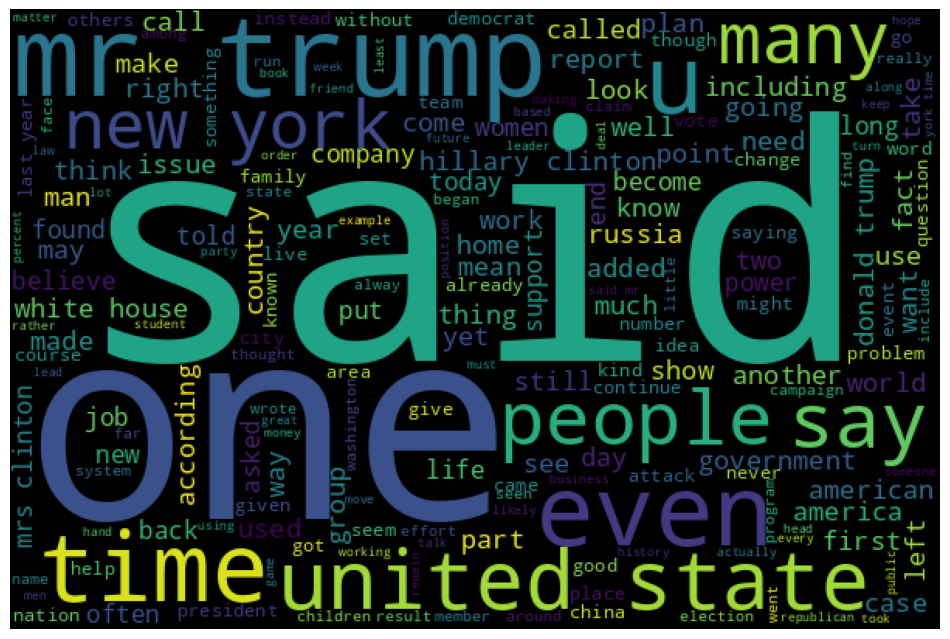

In [ ]:
#Word cloud for all word in train data

wordcloud = WordCloud( background_color='black', width=600, height=400)

text_cloud = wordcloud.generate(' '.join(news_df['text']))

plt.figure(figsize=(12,10))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

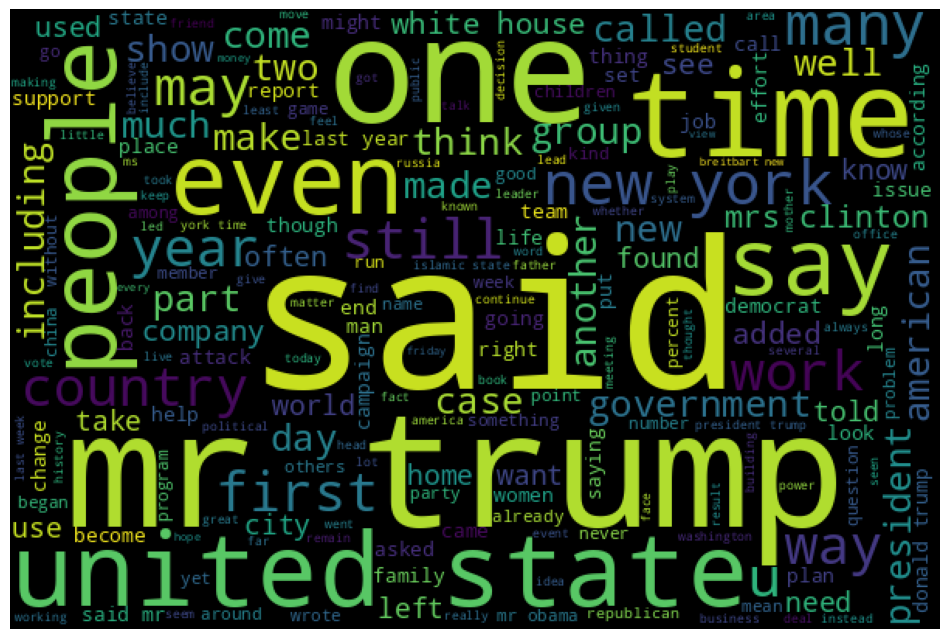

In [ ]:
#Word cloud for True label news only

true_news = ' '.join(news_df[news_df['label']==0]['text']) 
wc = wordcloud.generate(true_news)
plt.figure(figsize=(12,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

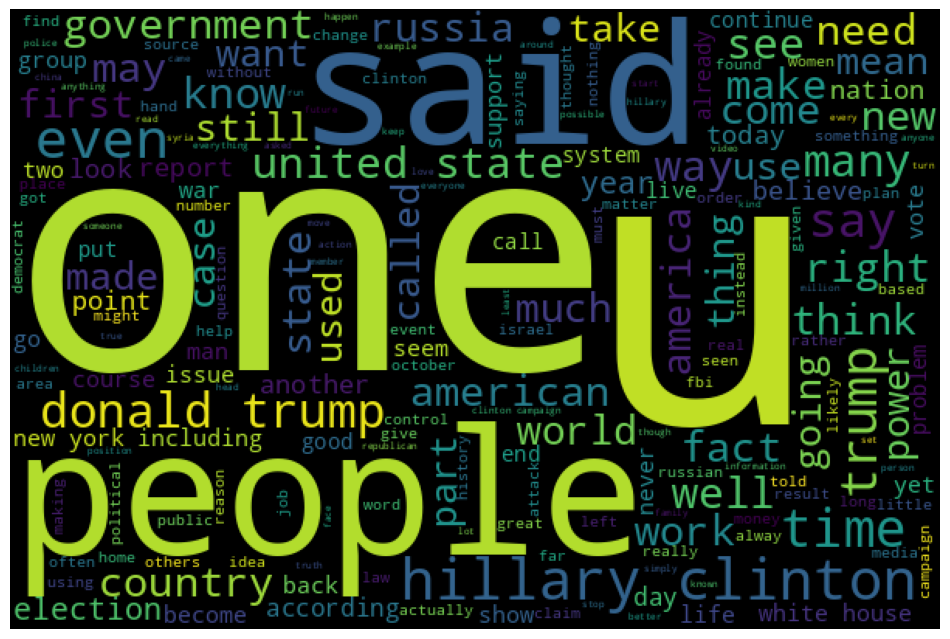

In [ ]:
#Word cloud for Fake label news only

fake_news = ' '.join(news_df[news_df['label']==1]['text'])
wc= wordcloud.generate(fake_news)
plt.figure(figsize=(12,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

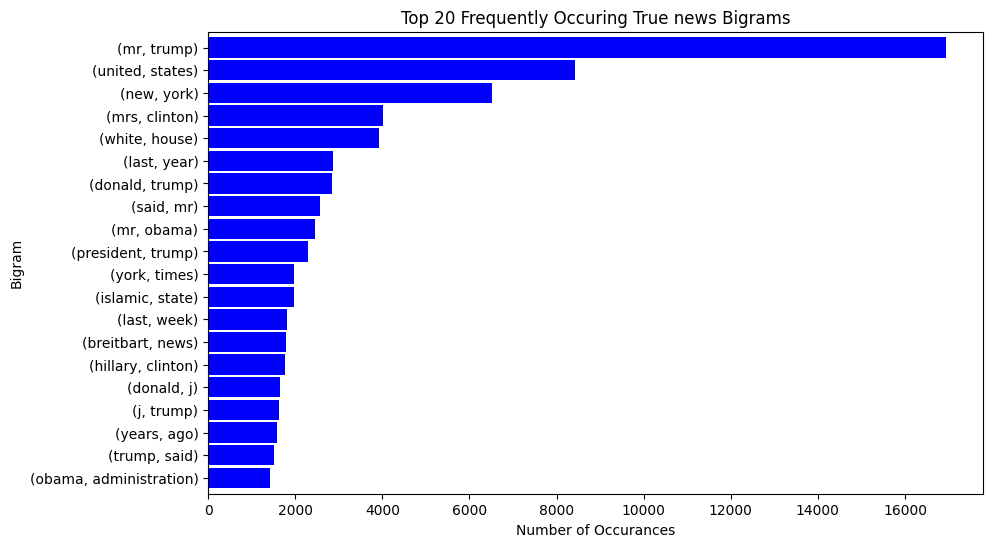

In [ ]:
##N-Gram
#Most frequent Bigram(Two word combination) of True label

true_bigrams = (pd.Series(nltk.ngrams(true_news.split(), 2)).value_counts())[:20]
true_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))
plt.title('Top 20 Frequently Occuring True news Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')
plt.show()

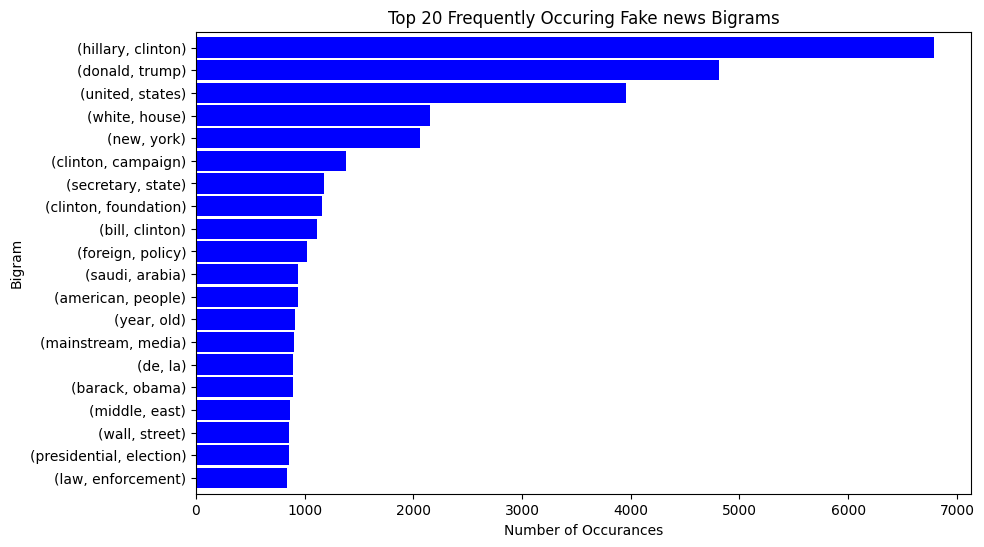

In [ ]:
#Most frequent Bigram(Two word combination) of Fake label

fake_bigrams = (pd.Series(nltk.ngrams(fake_news.split(), 2)).value_counts())[:20]
fake_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))
plt.title('Top 20 Frequently Occuring Fake news Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')
plt.show()

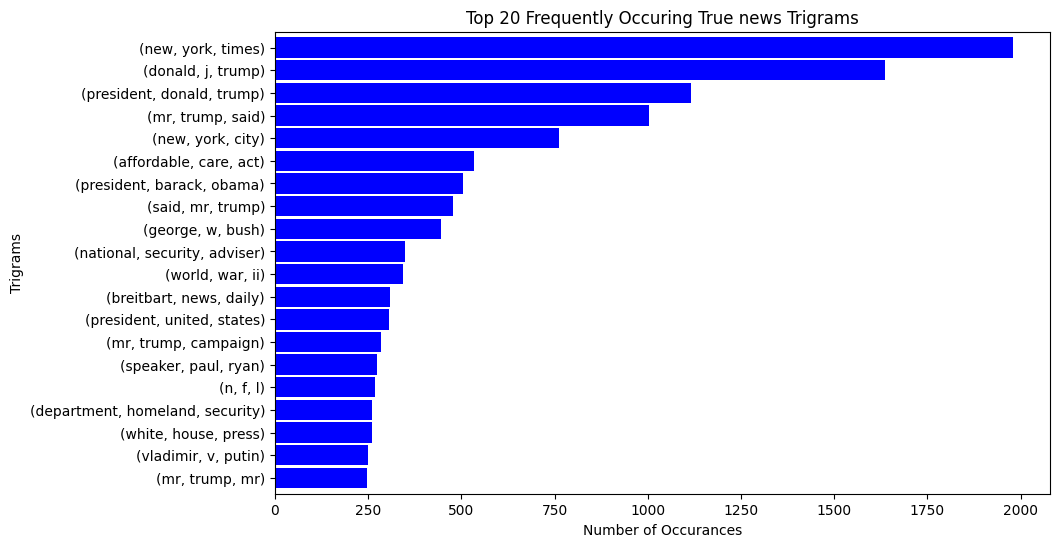

In [ ]:
#Most frequent Trigram(Three word combination) of True label

true_bigrams = (pd.Series(nltk.ngrams(true_news.split(), 3)).value_counts())[:20]
true_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))
plt.title('Top 20 Frequently Occuring True news Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('Number of Occurances')
plt.show()

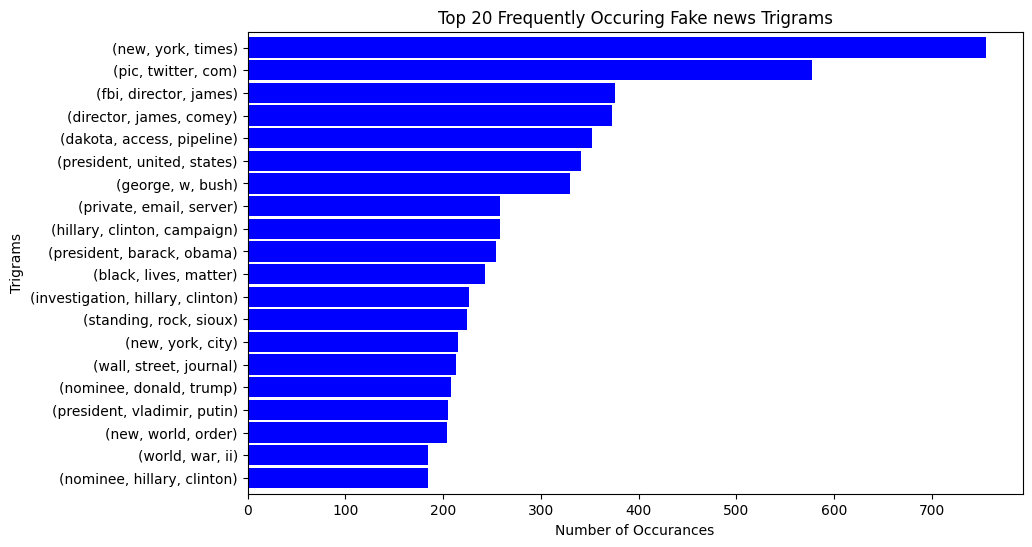

In [ ]:
#Most frequent Trigram(Three word combination) of Fake label

fake_bigrams = (pd.Series(nltk.ngrams(fake_news.split(), 3)).value_counts())[:20]
fake_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))
plt.title('Top 20 Frequently Occuring Fake news Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('Number of Occurances')
plt.show()


In [7]:
# Splitting training dataset into train and test for model selection and validation
def preparing_datasets(df):
    X = df['title'] + ' ' + df['text']
    y = df['label'].apply(lambda x: 1 if x == 'fake' else 0)
    return X, y

X_train, y_train = preparing_datasets(news_df)
X_test, y_test = preparing_datasets(submit_test)

In [22]:
# Tokenization and Padding
max_sequence_length = 10000
max_vocab_size = 20000

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [23]:
# Load GloVe embeddings (Pre-Trained GloVe embeddings used for LSTM and GRU models)
embedding_dim = 200
glove_model = api.load('glove-twitter-200')
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]

[==================================================] 100.0% 758.5/758.5MB downloaded


### Build Bidirectional LSTM model

In [24]:
# Build Bidirectional LSTM model (Long Short-Term Memory)
model_LSTM = Sequential()
model_LSTM.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model_LSTM.add(Bidirectional(LSTM(16)))
model_LSTM.add(BatchNormalization())
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(1, activation='sigmoid'))

model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 200)        29532200  
                                                                 
 bidirectional (Bidirectiona  (None, 32)               27776     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout_74 (Dropout)        (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,560,137
Trainable params: 27,873
Non-tr

In [25]:
# Train the Bidirectional LSTM model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

model_LSTM.fit(train_data, y_train, validation_data=(test_data, y_test), epochs=2, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model_LSTM.evaluate(test_data, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/2
650/650 [==============================] - 327s 494ms/step - loss: 0.1804 - accuracy: 0.9390 - val_loss: 0.3130 - val_accuracy: 0.9992
Epoch 2/2
163/163 [==============================] - 35s 216ms/step - loss: 0.0014 - accuracy: 1.0000
Test Loss: 0.0014
Test Accuracy: 1.0000


In [47]:
# Make predictions and get accuracy reports
y_pred_LSTM = model_LSTM.predict(test_data)
y_pred_labels_LSTM = np.argmax(y_pred_LSTM, axis=1)
print('Classification Report:')
print(classification_report(y_test, y_pred_labels_LSTM))

163/163 [==============================] - 31s 187ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5200

    accuracy                           1.00      5200
   macro avg       1.00      1.00      1.00      5200
weighted avg       1.00      1.00      1.00      5200



### Build Gated Recurrent Network (GRU) model

In [27]:
# Build Gated Recurrent Network (GRU) model

model_gru=Sequential()
model_gru.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model_gru.add((GRU(16)))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1,activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_gru.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10000, 200)        29532200  
                                                                 
 gru (GRU)                   (None, 16)                10464     
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_75 (Dropout)        (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29,542,745
Trainable params: 10,513
Non-trainable params: 29,532,232
_____________________________________

In [28]:
# Train the GRU model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

model_gru.fit(train_data, y_train, validation_data=(test_data, y_test), epochs=2, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model_gru.evaluate(test_data, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/2
650/650 [==============================] - 159s 241ms/step - loss: 0.3642 - accuracy: 0.8496 - val_loss: 0.0424 - val_accuracy: 1.0000
Epoch 2/2
163/163 [==============================] - 16s 97ms/step - loss: 0.0049 - accuracy: 1.0000
Test Loss: 0.0049
Test Accuracy: 1.0000


In [48]:
# Make predictions and get accuracy reports
y_pred_gru = model_gru.predict(test_data)
y_pred_labels_gru = np.argmax(y_pred_gru, axis=1)
print('Classification Report:')
print(classification_report(y_test, y_pred_labels_gru))

163/163 [==============================] - 15s 94ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5200

    accuracy                           1.00      5200
   macro avg       1.00      1.00      1.00      5200
weighted avg       1.00      1.00      1.00      5200



### Build Transformers model using Pre-Trained BERT Model

In [8]:
## Build Transformers model using Pre-Trained BERT Model (Bidirectional Encoder Representations from Transformers)

In [9]:
# Load the pre-trained Model and pre-trained Tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [10]:
# Tokenize and encode the training set
train_tokens = tokenizer.batch_encode_plus(
    X_train,
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='tf'
)

input_ids_train = train_tokens['input_ids']
attention_mask_train = train_tokens['attention_mask']

# Tokenize and encode the test set
test_tokens = tokenizer.batch_encode_plus(
    X_test,
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='tf'
)

input_ids_test = test_tokens['input_ids']
attention_mask_test = test_tokens['attention_mask']



In [11]:
# Build the model architecture
input_ids = Input(shape=(512,), dtype=tf.int32)
attention_mask = Input(shape=(512,), dtype=tf.int32)
outputs = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]
outputs = Dense(2, activation='softmax')(outputs)
model_transformer = Model(inputs=[input_ids, attention_mask], outputs=outputs)

# Set the pre-trained BERT weights as non-trainable
model_transformer.get_layer('tf_bert_model').trainable = False

In [12]:
# Compile the BERT Tranformer model
model_transformer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_transformer.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [13]:
# Fit the BERT Tranformer model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

model_transformer.fit(
    [input_ids_train, attention_mask_train],
    y_train,
    validation_data=([input_ids_test, attention_mask_test], y_test),
    batch_size=32,
    epochs=2,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model_transformer.evaluate([input_ids_test, attention_mask_test], y_test)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/2
650/650 [==============================] - 1183s 2s/step - loss: 0.0107 - accuracy: 0.9955 - val_loss: 1.8430e-04 - val_accuracy: 1.0000
Epoch 2/2
163/163 [==============================] - 210s 1s/step - loss: 5.5279e-05 - accuracy: 1.0000
Validation Loss: 0.0001
Validation Accuracy: 1.0000


In [18]:
# Save the model with custom objects
model_transformer.save('model_transformer')

# Load the model with custom objects
loaded_model_transformer = tf.keras.models.load_model('model_transformer', custom_objects={'TFBertModel': TFBertModel})


In [49]:
# Make predictions with the loaded model
y_pred_bert = loaded_model_transformer.predict([input_ids_test, attention_mask_test])
y_pred_labels_bert = np.argmax(y_pred_bert, axis=1)
print('Classification Report:')
print(classification_report(y_test, y_pred_labels_bert))

163/163 [==============================] - 209s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5200

    accuracy                           1.00      5200
   macro avg       1.00      1.00      1.00      5200
weighted avg       1.00      1.00      1.00      5200

